In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
from sklearn.model_selection import train_test_split 
import cv2 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns


In [3]:
def classification_report_nn(y_true, y_pred, classes):
    return classification_report(y_true, y_pred, target_names=classes)

In [4]:
def plot_roc_curve_multi_class(y_true, y_score, classes):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
# Path to dataset
dataset_path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images'

class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features_list = []
labels_list = []

First image from class Uninfected:


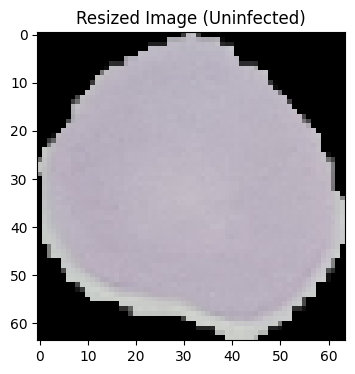

First image from class Parasitized:


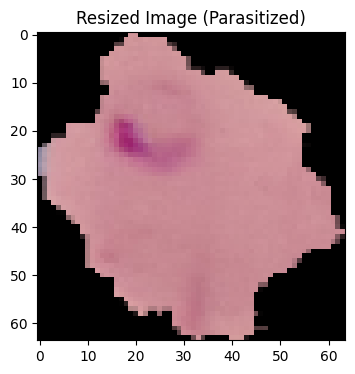

In [7]:
acceptable_extensions = {'.jpg', '.jpeg', '.png'}

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    image_filenames = os.listdir(class_folder)
    for i, image_filename in enumerate(image_filenames):
        file_extension = os.path.splitext(image_filename)[1].lower()
        if file_extension not in acceptable_extensions:
            continue
        image_path = os.path.join(class_folder, image_filename)
        image = io.imread(image_path)
        resized_image = cv2.resize(image, (64, 64))
        if i == 0:
            print(f"First image from class {class_name}:")
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(resized_image, cmap=plt.cm.gray)
            ax.set_title(f'Resized Image ({class_name})')
            plt.show()
        features_list.append(resized_image)
        labels_list.append(class_name)

In [8]:
# Convert lists to arrays and preprocess
features_array = np.array(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

In [9]:
# Shuffle and split the data
features_array, numeric_labels = shuffle(features_array, numeric_labels, random_state=74)
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.2, random_state=42)

In [10]:
# Normalize the image data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [11]:
# Flatten the images for input into the dense neural network
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [12]:
# Build a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_flat.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  # Increased dropout for regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience for stability
    restore_best_weights=True
)

In [14]:
# Train the model
history = model.fit(
    X_train_flat, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.5065 - loss: 8.1168 - val_accuracy: 0.4778 - val_loss: 3.3216
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5173 - loss: 2.8376 - val_accuracy: 0.4778 - val_loss: 1.9058
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5301 - loss: 1.7035 - val_accuracy: 0.4778 - val_loss: 1.2843
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5402 - loss: 1.2076 - val_accuracy: 0.4778 - val_loss: 1.0065
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.5617 - loss: 0.9608 - val_accuracy: 0.5435 - val_loss: 0.9839
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5832 - loss: 0.8746 - val_accuracy: 0.5701 - val_loss: 0.8260
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.5973 - loss: 0.8069 - val_accuracy: 0.5560 - val_loss: 0.8530
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6026 - loss: 0.7989 - 

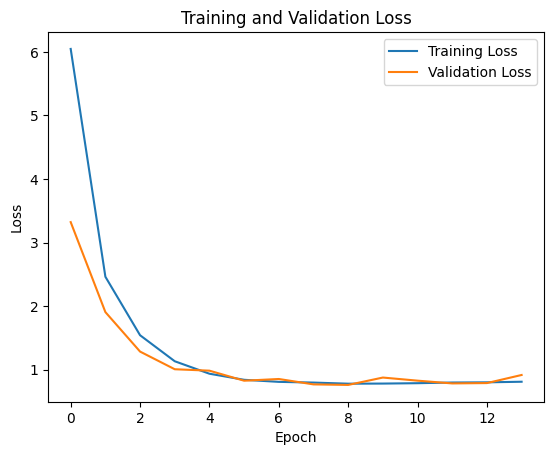

In [15]:
# Compare training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Predictions and evaluation
y_pred_nn = model.predict(X_test_flat)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [17]:
# Classification report
classification_rep_nn = classification_report_nn(y_test, y_pred_nn_classes, label_encoder.classes_)
print("Classification Report for Neural Network Model:")
print(classification_rep_nn)

Classification Report for Neural Network Model:
              precision    recall  f1-score   support

 Parasitized       0.64      0.61      0.62      2788
  Uninfected       0.62      0.65      0.64      2724

    accuracy                           0.63      5512
   macro avg       0.63      0.63      0.63      5512
weighted avg       0.63      0.63      0.63      5512



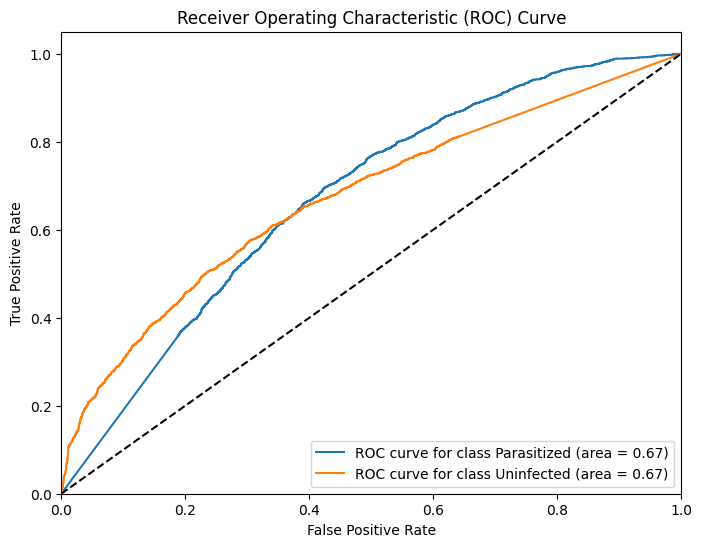

In [18]:
# Plot the ROC curve
plot_roc_curve_multi_class(y_test, y_pred_nn, label_encoder.classes_)

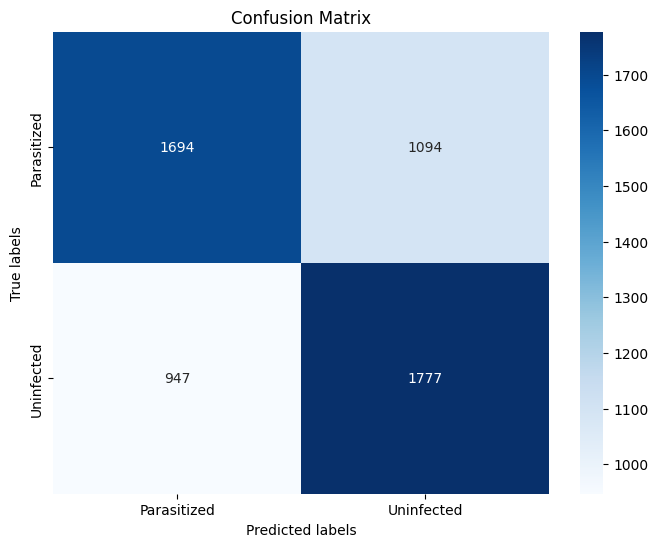

In [19]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_nn_classes, label_encoder.classes_)